# ZOMBIE DETECTOR: Using ML to save lives during a Zombie Apocalypse


## About Dataset

### Context
News reports suggest that the impossible has become possible…zombies have appeared on the streets! What should we do? The Centers for Disease Control and Prevention (CDC) zombie preparedness website recommends storing water, food, medication, tools, sanitation items, clothing, essential documents, and first aid supplies. Thankfully, we are CDC analysts and are prepared, but it may be too late for others!

### Content
Our team decides to identify supplies that protect people and coordinate supply distribution. A few brave data collectors volunteer to check on 200 randomly selected adults who were alive before the zombies. We have recent data for the 200 on age and sex, how many are in their household, and their rural, suburban, or urban location. Our heroic volunteers visit each home and record zombie status and preparedness. Now it's our job to figure out which supplies are associated with safety!

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import pickle

import warnings  
warnings.filterwarnings('ignore')

### Read Data

In [2]:
zombies = pd.read_csv("zombies.csv", index_col="zombieid")

In [3]:
zombies

,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
zombieid,,,,,,,,,,,,,
1,Human,18,Female,Rural,1,0,Food,Medication,No tools,First aid supplies,Sanitation,Clothing,NaN
2,Human,18,Male,Rural,3,24,Food,Medication,tools,First aid supplies,Sanitation,Clothing,NaN
3,Human,18,Male,Rural,4,16,Food,Medication,No tools,First aid supplies,Sanitation,Clothing,NaN
4,Human,19,Male,Rural,1,0,Food,Medication,tools,No first aid supplies,Sanitation,Clothing,NaN
5,Human,19,Male,Urban,1,0,Food,Medication,No tools,First aid supplies,Sanitation,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Zombie,68,Male,Suburban,1,0,Food,No medication,No tools,No first aid supplies,Sanitation,Clothing,Documents
197,Zombie,71,Male,Suburban,1,8,No food,No medication,tools,First aid supplies,No sanitation,Clothing,NaN
198,Zombie,76,Female,Urban,1,0,No food,No medication,tools,First aid supplies,Sanitation,Clothing,Documents


## Exploratory Data Analysis

In [4]:
# Descriptive Analytics
print(zombies.describe())

              age   household       water
count  200.000000  200.000000  200.000000
mean    44.415000    2.680000    8.750000
std     17.371865    1.263162   12.069626
min     18.000000    1.000000    0.000000
25%     29.000000    2.000000    0.000000
50%     42.000000    2.500000    8.000000
75%     58.000000    4.000000    8.000000
max     85.000000    6.000000   40.000000


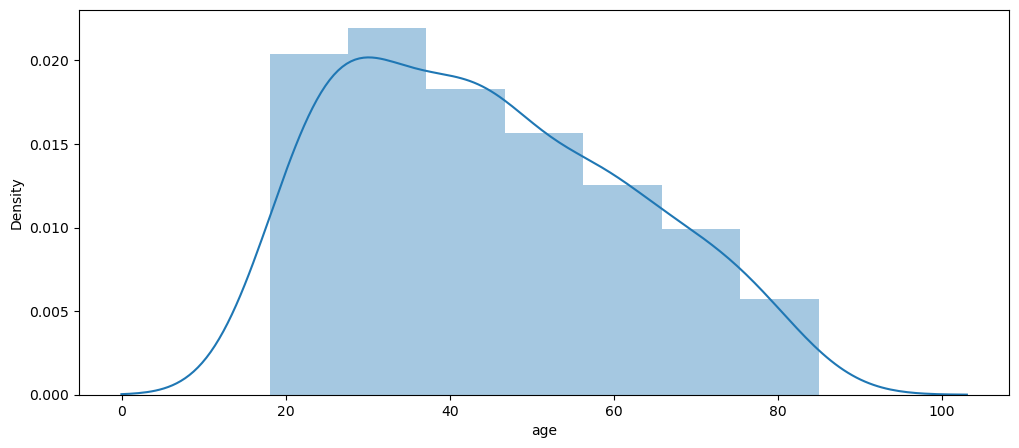

In [5]:
#Plotting Age
fig = plt.figure(figsize=(12,5))
sns.distplot(zombies['age'])
plt.show()

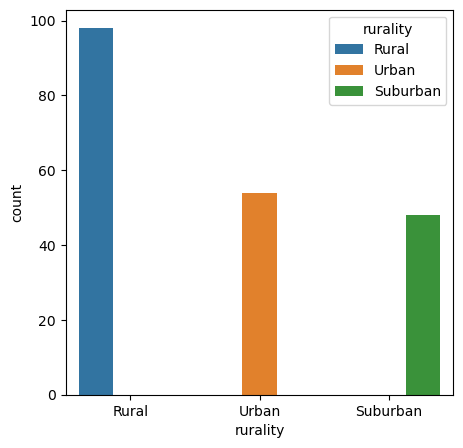

In [6]:
#Plotting Rurality
fig = plt.figure(figsize=(5,5))
sns.countplot(x=zombies['rurality'], data=zombies['rurality'], hue=zombies['rurality'])
plt.show()

### Compare humans and zombies - Part 1

Because every moment counts when dealing with life and (un)death, we want to get this right! The first task is to compare humans and zombies to identify differences in supplies. We review the data and find the following:

In [7]:
# Create water-per-person
zombies['water.person'] = zombies['water'] / zombies['household']

# Examine the new variable 
print(zombies['water.person'].describe())

count    200.000000
mean       3.091833
std        3.627677
min        0.000000
25%        0.000000
50%        2.000000
75%        5.333333
max       13.333333
Name: water.person, dtype: float64


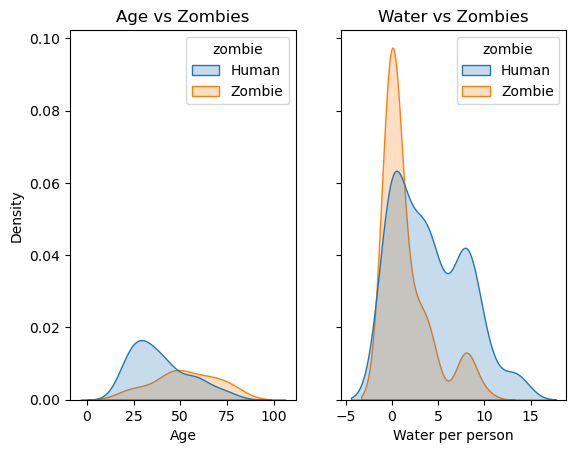

In [8]:
# Create the ageZombies graph
f, (ageZombies, waterPersonZom) = plt.subplots(1, 2, sharey=True)
ageZombies = sns.kdeplot(data = zombies, x = "age", fill = True, hue = "zombie", ax=ageZombies) 
ageZombies.set(title="Age vs Zombies", xlabel="Age", ylabel="Density")

# Create the waterPersonZom graph
waterPersonZom = sns.kdeplot(data = zombies, x = "water.person", fill = True, hue = "zombie", ax=waterPersonZom) 
waterPersonZom.set(title="Water vs Zombies", xlabel="Water per person", ylabel="Density")

plt.show()

It looks like those who turned into zombies were older and had less available clean water. This suggests that getting water to the remaining humans might help protect them from the zombie hoards! Protecting older citizens is important, so we need to think about the best ways to reach this group.

### Compare Humans and Zombies - Part 2

Other than age and water, what are the other characteristics and supplies that differ between humans and zombies? Do zombies live in urban areas? Or are they more common in rural areas? Is water critical to staying human? Is food critical to staying human?

In [9]:
#Compare categorical Features
zombies_factors = zombies.select_dtypes(include='object')
# Write a function to get percent zombies
perc_zombies = [pd.crosstab(zombies_factors[x],zombies['zombie'], normalize='index') 
                for x in zombies_factors.columns
               ]
# Print the data
for df in perc_zombies:
    print(df,"\n")

zombie  Human  Zombie
zombie               
Human     1.0     0.0
Zombie    0.0     1.0 

zombie     Human    Zombie
sex                       
Female  0.626263  0.373737
Male    0.584158  0.415842 

zombie       Human    Zombie
rurality                    
Rural     0.816327  0.183673
Suburban  0.520833  0.479167
Urban     0.296296  0.703704 

zombie      Human    Zombie
food                       
Food     0.827273  0.172727
No food  0.333333  0.666667 

zombie            Human    Zombie
medication                       
Medication     0.829787  0.170213
No medication  0.405660  0.594340 

zombie       Human    Zombie
tools                       
No tools  0.603960  0.396040
tools     0.606061  0.393939 

zombie                    Human    Zombie
firstaid                                 
First aid supplies     0.632075  0.367925
No first aid supplies  0.574468  0.425532 

zombie            Human    Zombie
sanitation                       
No sanitation  0.470588  0.529412
Sanitation 

<AxesSubplot:>

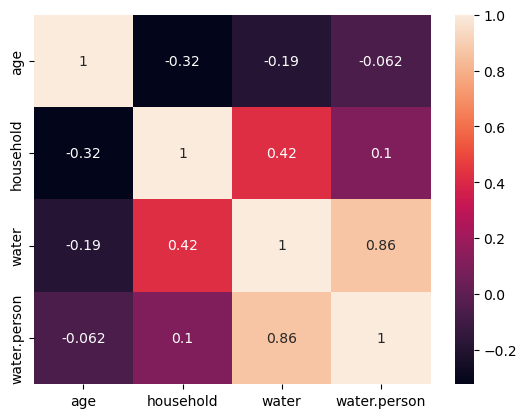

In [10]:
sns.heatmap(zombies.corr(),annot=True)

## Data Preprocessing: Recode variables & missing values

In [260]:
zombies.shape

(200, 14)

In [261]:
zombies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zombie        200 non-null    object 
 1   age           200 non-null    int64  
 2   sex           200 non-null    object 
 3   rurality      200 non-null    object 
 4   household     200 non-null    int64  
 5   water         200 non-null    int64  
 6   food          200 non-null    object 
 7   medication    200 non-null    object 
 8   tools         200 non-null    object 
 9   firstaid      200 non-null    object 
 10  sanitation    200 non-null    object 
 11  clothing      126 non-null    object 
 12  documents     66 non-null     object 
 13  water.person  200 non-null    float64
dtypes: float64(1), int64(3), object(10)
memory usage: 31.5+ KB


In [262]:
#Check for null values
np.sum(zombies.isnull())

zombie            0
age               0
sex               0
rurality          0
household         0
water             0
food              0
medication        0
tools             0
firstaid          0
sanitation        0
clothing         74
documents       134
water.person      0
dtype: int64

In [263]:
#Check datatype of all features
dataTypeSeries = zombies.dtypes
print('Data type of each column of timesData Dataframe :')
print(dataTypeSeries)

Data type of each column of timesData Dataframe :
zombie           object
age               int64
sex              object
rurality         object
household         int64
water             int64
food             object
medication       object
tools            object
firstaid         object
sanitation       object
clothing         object
documents        object
water.person    float64
dtype: object


In [264]:
#Convert Columns with null values into data type category
for col in ['clothing', 'documents']:
    zombies[col] = zombies[col].astype('category')

In [265]:
#Check if conversion successfull    
dataTypeSeries = zombies.dtypes
print('Data type of each column of timesData Dataframe :')
print(dataTypeSeries)

Data type of each column of timesData Dataframe :
zombie            object
age                int64
sex               object
rurality          object
household          int64
water              int64
food              object
medication        object
tools             object
firstaid          object
sanitation        object
clothing        category
documents       category
water.person     float64
dtype: object


In [266]:
# Add new level and recode NA to "No clothing"
zombies["clothing"] = pd.Categorical(zombies["clothing"], categories=pd.unique(zombies["clothing"].cat.categories.append(pd.Index(["No clothing"]))))
zombies['clothing'].fillna('No clothing', inplace=True)

# Add new level and recode NA to "No documents"
zombies["documents"] = pd.Categorical(zombies["documents"], categories=pd.unique(zombies["documents"].cat.categories.append(pd.Index(["No documents"]))))
zombies['documents'].fillna('No documents', inplace=True)

# Check recoding
np.sum(zombies.isnull())

zombie          0
age             0
sex             0
rurality        0
household       0
water           0
food            0
medication      0
tools           0
firstaid        0
sanitation      0
clothing        0
documents       0
water.person    0
dtype: int64

In [12]:
# Initializing LabelEncoder object
le = LabelEncoder()

# Converting categorical columns to numerical using Label Encoding
zombies['sex'] = le.fit_transform(zombies['sex'])
zombies['rurality'] = le.fit_transform(zombies['rurality'])
zombies['food'] = le.fit_transform(zombies['food'])
zombies['medication'] = le.fit_transform(zombies['medication'])
zombies['tools'] = le.fit_transform(zombies['tools'])
zombies['firstaid'] = le.fit_transform(zombies['firstaid'])
zombies['sanitation'] = le.fit_transform(zombies['sanitation'])
zombies['clothing'] = le.fit_transform(zombies['clothing'])
zombies['documents'] = le.fit_transform(zombies['documents'])

In [13]:
zombies.head()

,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents,water.person
zombieid,,,,,,,,,,,,,,
1,Human,18,0,0,1,0,0,0,0,0,1,0,1,0.0
2,Human,18,1,0,3,24,0,0,1,0,1,0,1,8.0
3,Human,18,1,0,4,16,0,0,0,0,1,0,1,4.0
4,Human,19,1,0,1,0,0,0,1,1,1,0,1,0.0
5,Human,19,1,2,1,0,0,0,0,0,1,1,1,0.0


## Build Model

In [14]:
# Splitting data into features and target
X = zombies.drop(['zombie','water.person'], axis=1)
y = zombies['zombie']

In [268]:
# Initializing LabelEncoder object
le = LabelEncoder()

# Converting categorical columns to numerical using Label Encoding
X['sex'] = le.fit_transform(X['sex'])
X['rurality'] = le.fit_transform(X['rurality'])
X['food'] = le.fit_transform(X['food'])
X['medication'] = le.fit_transform(X['medication'])
X['tools'] = le.fit_transform(X['tools'])
X['firstaid'] = le.fit_transform(X['firstaid'])
X['sanitation'] = le.fit_transform(X['sanitation'])
X['clothing'] = le.fit_transform(X['clothing'])
X['documents'] = le.fit_transform(X['documents'])

In [15]:
#Features
X

,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
zombieid,,,,,,,,,,,,
1,18,0,0,1,0,0,0,0,0,1,0,1
2,18,1,0,3,24,0,0,1,0,1,0,1
3,18,1,0,4,16,0,0,0,0,1,0,1
4,19,1,0,1,0,0,0,1,1,1,0,1
5,19,1,2,1,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
196,68,1,1,1,0,0,1,0,1,1,0,0
197,71,1,1,1,8,1,1,1,0,0,0,1
198,76,0,2,1,0,1,1,1,0,1,0,0


In [16]:
#Target Variable
y

zombieid
1       Human
2       Human
3       Human
4       Human
5       Human
        ...  
196    Zombie
197    Zombie
198    Zombie
199    Zombie
200    Zombie
Name: zombie, Length: 200, dtype: object

In [271]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [272]:
# Defining the models
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC()

# Training and predicting with each model
for model in [lr, dt, rf, svm]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluating the model
    acc_score = accuracy_score(y_test, y_pred)
    clf_report = classification_report(y_test, y_pred)
    
    print(f'Model: {type(model).__name__}')
    print(f'Accuracy score: {acc_score:.2f}')
    print(f'Classification report:\n{clf_report}\n')

Model: LogisticRegression
Accuracy score: 0.97
Classification report:
              precision    recall  f1-score   support

       Human       1.00      0.96      0.98        26
      Zombie       0.93      1.00      0.97        14

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40


Model: DecisionTreeClassifier
Accuracy score: 0.85
Classification report:
              precision    recall  f1-score   support

       Human       0.95      0.81      0.88        26
      Zombie       0.72      0.93      0.81        14

    accuracy                           0.85        40
   macro avg       0.84      0.87      0.84        40
weighted avg       0.87      0.85      0.85        40


Model: RandomForestClassifier
Accuracy score: 0.93
Classification report:
              precision    recall  f1-score   support

       Human       1.00      0.88      0.94        26
      Zombie     

In [273]:
y_pred = lr.predict([[18,0,0,1,0,0,0,0,0,1,0,1]])
print(y_pred)

['Human']


# Pickle file

In [131]:
filename = 'model.pkl'
pickle.dump(lr,open(filename,'wb'))